In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import scipy.stats as stats
import math
import sklearn.preprocessing

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# train test split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

import acquire 
import explore as e
import wrangle as w
import regression_models as m

import warnings
warnings.filterwarnings("ignore")

# Acquire

* I acquired this data from the Codeup database using mySQL workbench
* Each observation or row provides a value or description of a home
* Each column represents a feature of the property
* I acquired this data on Wednesday November 15th 

# Prepare

* Nulls coverted to zero and zeros reomoved from data set explored
* Max sqft to 2500
* Max bedrooms of 6 
* Max bathrooms of 6 
* Half bathrooms rounded up to whole bathrooms
* Max property value of 1 Million
* Split data into train, validate and test(approx. 50/30/20)
* Converted fips numeric value to string value 
* Encoded Fips location strings into ones and zeros
* Renamed multiple columns : bedrooms, bathrooms, complete square footage 

 

In [2]:
#create, train, validate, test datasets
train, validate, test = w.wrangle_zillow()

# Exploration of Data

### What is the median and mean home price? 

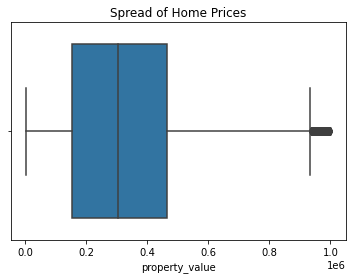

In [3]:
# creates boxplot of property values
e.boxplot(train,"property_value", "Spread of Home Prices")

In [4]:
# Mean compared to Median 
e.statistic_table(train)

Metric         Value
----------  --------
Median      304006
Mean        331975
Difference   27969.2


### Takeaways

- The median property value is 304,006 dollars
- The mean property value is 331,975 dollars
- The difference between these values is 27,969 dollars

# Statistical Questions

### Is there a significant difference in mean property value across Los Angeles, Ventura  and Orange County?  

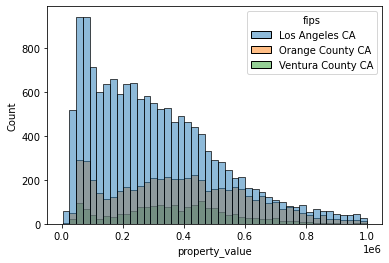

In [5]:
# creates histogram of properties in counties
e.hists(train)

In [6]:
# Count of properties in each County
e.value_counts(train)

Los Angeles CA       15031
Orange County CA      5706
Ventura County CA     1773
Name: fips, dtype: int64

### Hypothesis

- Ho: There is no difference in mean property values across Los Angeles County, Ventura County and Orange County<br>
- Ha: There is a significant difference in mean property values across Los Angeles County, Ventura County and Orange County

In [7]:
# results of Anova statistical test 
e.stats_property_location(train)

Kruska Result = 741.2514
p = 1.0947481547835832e-161


### Takeaways 

- There is a significant difference in the mean property value of the homes across Los Angeles, Ventura and Orange County 
- There appears to be a higher frequency of homes being sold in Los Angeles compared to the other counties
- Fips should be considered for modeling
- Los Angeles has widest spread of property values



### Is there a correlation between square footage and property value?  

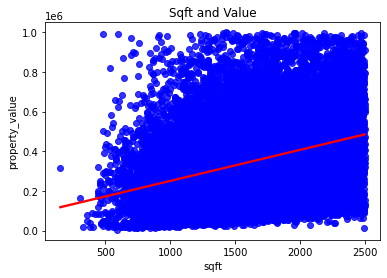

In [8]:
#visualization of sqft vs property value 
e.scatter_plot(train)

### Hypothesis: 

Ho: There is no correlation between home square footage and property value.<br>
Ha: There is a correlation between home square footage and property value.

In [9]:
# Statistc test results
e.correlation_stat_test(train,'sqft')

Correlation Strength = 0.3230
p = 0.0


### Takeaways
- Appears that as sqft increases the property value increases
- The test results show support for a relationship between the two variables and a positive correlation
- Square footage should be a feature that is considered for modeling

### Is there a correlation between the bathrooms  and property value ?  

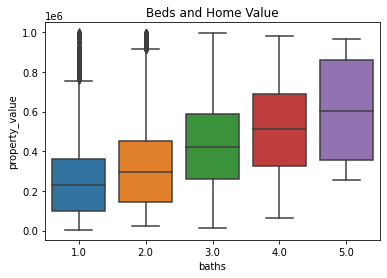

In [10]:
# box plot Bathrooms vs Property value 
e.two_variable_boxplots(train,'baths','Beds and Home Value')

### Hypothesis: 

Ho: There is no correlation between number of baths and property value.<br>
Ha: There is a correlation between number of baths and property value.


In [11]:
# Statistical test results 
e.correlation_stat_test(train,'baths')

Correlation Strength = 0.2842
p = 0.0


### Takeaways

- There is a positive correlation between bathrooms and property value
- Median value of properties appears to increase with each additional bathroom 

### Is there a correlation between the room count and property value ?  

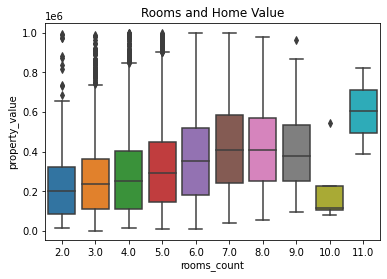

In [12]:
# box plot Rooms vs Property value 
e.two_variable_boxplots(train,'rooms_count', 'Rooms and Home Value')

### Hypothesis

Ho: There is no correlation between number of rooms and property value.<br>
Ha: There is a correlation between number of rooms and property value.

In [13]:
# Statistical test results 
e.correlation_stat_test(train,'rooms_count')

Correlation Strength = 0.2265
p = 9.974046059473551e-260


### Takeaways

- Property value appears to increase with each room until 7 rooms
- Bathrooms may have a larger impact to home value compared to bedrooms (Bathrooms has stronger correlation)
- Adding additional bathroom to a home may be more valuable than adding another bedroom
- Rooms count has a positive correlation with home value and will be considered for modeling

## Exploration Summary

- The median property value is 304,006 dollars
- The features used for modeling will be baths, rooms count and sqft
- The statistical tests provide support that there is a correlation between Property value and baths, beds, sqft
- Statistical testing supports a significant relationship between fips code and property value 
- There is a significant difference in the mean property value of the homes across Los Angeles, Ventura and Orange County 
- There appears to be a higher frequency of homes being sold in Los Angeles compared to the other counties
- The mean property value is 331,975 dollars






# Modeling

### Introduction

- I will use Root Mean Squared error as my evaluation metric
- My baseline model is created from the Root Mean Squared error (RMSE) of the median property value of the train and validate data set
- The features chosen for the models are bathroom count, total rooms and square feet of the home
- Models will be evaluated on train and validate data sets 
- The model that performs the best will be evaluated on the test data

In [14]:
# prepare data for models
X_train, X_validate, y_train, y_validate, X_test, y_test = m.model_columns(train,validate,test)

## Baseline Model

In [15]:
# creating baseline model and printing results
m.baseline_model(y_train,y_validate)

RMSE using Median
Train/In-Sample:  215215.43 
Validate/Out-of-Sample:  218227.96


In [16]:
# scaling features for modeling
X_train_scaled, X_validate_scaled, X_test_scaled = m.scaling(X_train,X_validate,X_test)

## LassoLars 

In [17]:
# Lasso Lars model result
m.lassolars(X_train_scaled,X_validate_scaled,y_train,y_validate)

RMSE for Lasso + Lars
Training/In-Sample:  200298.86894053587 
Validation/Out-of-Sample:  202564.816833445


### Takeaways 
- model performs better than baseline 

## TweedieRegressor(GLM) 

In [18]:
# Tweedie Regressor model results
m.tweedie(X_train_scaled,X_validate_scaled,y_train,y_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  200216.40150063235 
Validation/Out-of-Sample:  202564.70934418403


## Takeaways
- performs better than baseline 


## Polynomial Regression 

In [19]:
# generating polynomial regression model results
m.linear_reg(X_train_scaled,X_validate_scaled,y_train,y_validate)

RMSE for Polynomial Model, degrees=4
Training/In-Sample:  199869.8003363903 
Validation/Out-of-Sample:  202539.8924280777


## Takeaways
- performs better than baseline 


## Best Model

- ####   Polynomial Regression Model Wins!

## Test Model
- I will run my Polynomial Regression on my test data

In [20]:
# using model on test dataset 
m.polynomial_reg(X_test_scaled, y_test)

RMSE for Polynomial Model, Results:  202757.41657260247


### Modeling Wrap 

* I would recommend this model for production because it is roughly a 7% improvement from the baseline

## Conclusion

### Summary
- Statistical evidence supports correlations between property value and bathrooms, total rooms and square feet of a home respectively
- Statistical testing supports a significant relationship between fips code and property value 
- The median property value is 304,006 dollars
- There appears to be a higher frequency of homes being sold in Los Angeles compared to the other counties
- There is a significant difference in the mean property value of the homes across Los Angeles, Ventura and Orange County 


### Modeling Summary 
- My model uses bathrooms, room count and square footage to predict a home's value
- The final model performed approximately 7% better than the baseline
- I would recommend this model for production


### Recommendations
* Have a team meeting to discuss how to analyze features specifc to location
* Request more data to balance out the representation of transactions in Orange County and Ventura County 


### Next Steps
* Take time to build a model solely based on location features
* Look further into Los Angeles transactions impact on data